
Tweets classified as agressive or not


Dataset https://www.kaggle.com/dataturks/dataset-for-detection-of-cybertrolls

The dataset has 20001 items of which 20001 items have been manually labeled.

The labels are divided into following 2 categories:

1 - Cyber-Aggressive 0 - Non Cyber-Aggressive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import json
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.model_selection import StratifiedKFold

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_json('/content/gdrive/My Drive/Dataset for Detection of Cyber-Trolls.json', lines= True)
df.head()

,content,annotation,extras
0,Get fucking real dude.,"{'notes': '', 'label': ['1']}",NaN
1,She is as dirty as they come and that crook ...,"{'notes': '', 'label': ['1']}",NaN
2,why did you fuck it up. I could do it all day...,"{'notes': '', 'label': ['1']}",NaN
3,Dude they dont finish enclosing the fucking s...,"{'notes': '', 'label': ['1']}",NaN
4,WTF are you talking about Men? No men thats n...,"{'notes': '', 'label': ['1']}",NaN


In [5]:
df.shape

(20001, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   content     20001 non-null  object 
 1   annotation  20001 non-null  object 
 2   extras      0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 468.9+ KB


In [8]:
df.drop(columns = ['extras'], inplace = True)

In [9]:
df.rename(columns = {'annotation' : 'label'}, inplace = True)

In [10]:
df.label = df.label.apply(lambda x : int(x['label'][0]))

In [11]:
df.head()

,content,label
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook ...,1
2,why did you fuck it up. I could do it all day...,1
3,Dude they dont finish enclosing the fucking s...,1
4,WTF are you talking about Men? No men thats n...,1


In [12]:
df[df['label'] == 0].sample(5).content

15855                     smile hahah and say thank you :)
11365    damn Lowkey found his future wifey  go make lo...
11041    Wel get ur ass over here just dnt be loud guh ...
16207      1. I am totally able to telepathically read ...
15864      buncha kind things have been done for me. BU...
Name: content, dtype: object

In [13]:
df[df['label'] == 1].sample(5).content

774      RT this then GO fuck yourself stay the FUCL o...
7174    but you know what i hate ? the comments that a...
3061    its ok decided not to go to fam party. going b...
3054    Excited that yr friends get to see yr show. I ...
3990    Would it piss off Bill O'Reilly if I wished yo...
Name: content, dtype: object

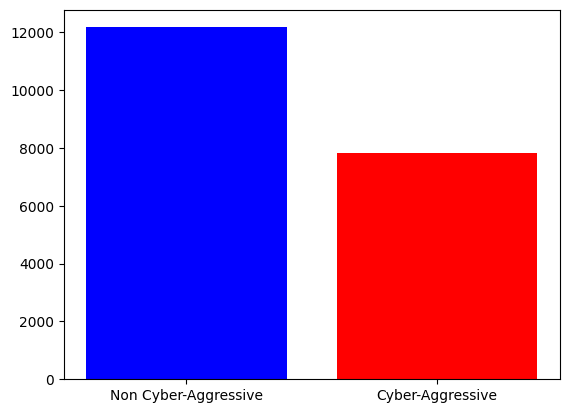

In [14]:
_, ax = plt.subplots()
plt.bar(np.arange(2), df['label'].value_counts(), color = ['blue', 'red'])
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['Non Cyber-Aggressive', 'Cyber-Aggressive']);

In [15]:
df['label'].value_counts()[1] / df.shape[0], df['label'].value_counts()[0] / df.shape[0]

(0.39108044597770114, 0.6089195540222989)

In [16]:
df['len'] = df['content'].apply(lambda x : len(x.strip().split()))

In [17]:
import regex as re 

In [18]:
df['capital'] = df['content'].apply(lambda x : sum(1 for c in x if c.isupper()))

In [19]:
df['punct'] = df['content'].apply(lambda x : len(re.findall("[^\P{P}-]+", x)))
df['punct'] = df['content'].apply(lambda x : len(re.findall("[^\P{P}-]+", x)))

In [20]:
df['content'] = df['content'].apply(lambda x : re.sub("[^\P{P}-]+", "", x))   
df['content'] = df['content'].apply(lambda x : str.lower(x))

In [21]:
symbols = {}
for x in [item for sublist in list(map(list, df['content'].tolist())) for item in sublist] :
    if x in symbols :
        symbols[x] += 1
    else :
        symbols[x] = 1
symbols

{' ': 257558,
 'g': 24486,
 'e': 104464,
 't': 91603,
 'f': 19569,
 'u': 40885,
 'c': 26567,
 'k': 19024,
 'i': 71229,
 'n': 61949,
 'r': 46623,
 'a': 86393,
 'l': 43265,
 'd': 36600,
 's': 63639,
 'h': 58545,
 'y': 32553,
 'o': 86476,
 'm': 30832,
 'p': 17412,
 'j': 3000,
 'b': 16983,
 'w': 24918,
 'v': 9412,
 '1': 769,
 '7': 232,
 '6': 243,
 '0': 1019,
 'x': 1588,
 '-': 2121,
 '2': 941,
 '4': 400,
 '5': 374,
 'q': 864,
 '9': 294,
 '3': 1023,
 '$': 137,
 'z': 1460,
 '8': 363,
 '^': 50,
 '=': 241,
 '~': 67,
 '+': 131,
 '`': 7,
 '<': 203,
 '>': 35,
 '|': 15}

In [22]:
digits = '0123456789'
df['num'] = df['content'].apply(lambda x : 1 if len([s for s in x if s in digits]) > 0 else 0)

In [23]:
df.head()

,content,label,len,capital,punct,num
0,get fucking real dude,1,4,1,1,0
1,she is as dirty as they come and that crook ...,1,25,5,3,0
2,why did you fuck it up i could do it all day ...,1,30,3,5,0
3,dude they dont finish enclosing the fucking s...,1,21,4,4,0
4,wtf are you talking about men no men thats no...,1,15,5,3,0


In [24]:
target = df['label'].values


Split dataset on train and test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.3, stratify = target, random_state = 31)
y_train.sum() / len(y_train), y_test.sum() / len(y_test)

(0.39107142857142857, 0.39110148308615234)

In [26]:
X_train.shape, X_test.shape

((14000, 6), (6001, 6))

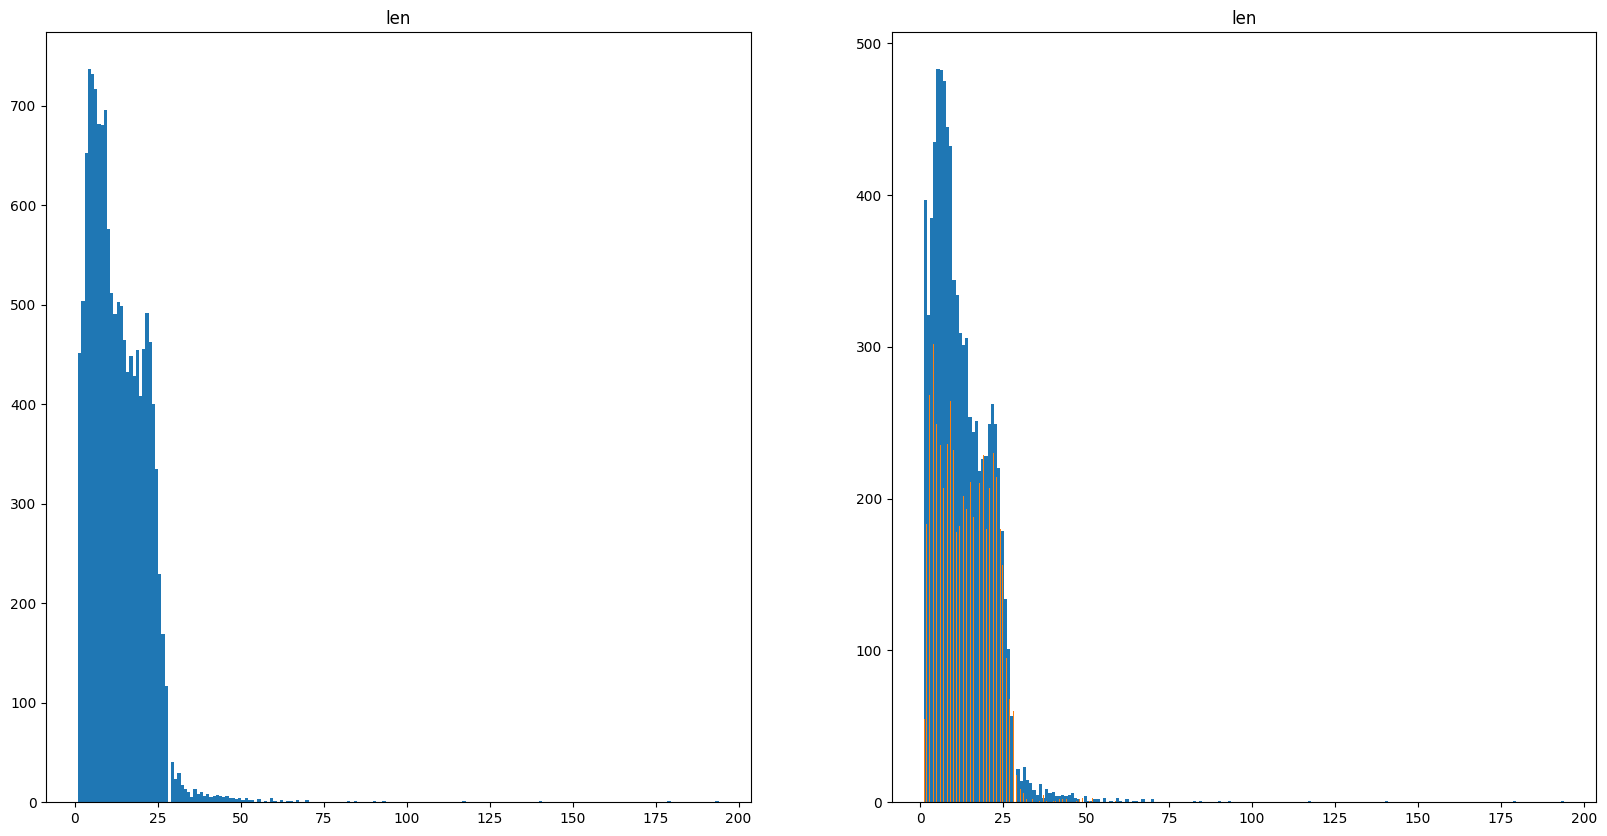

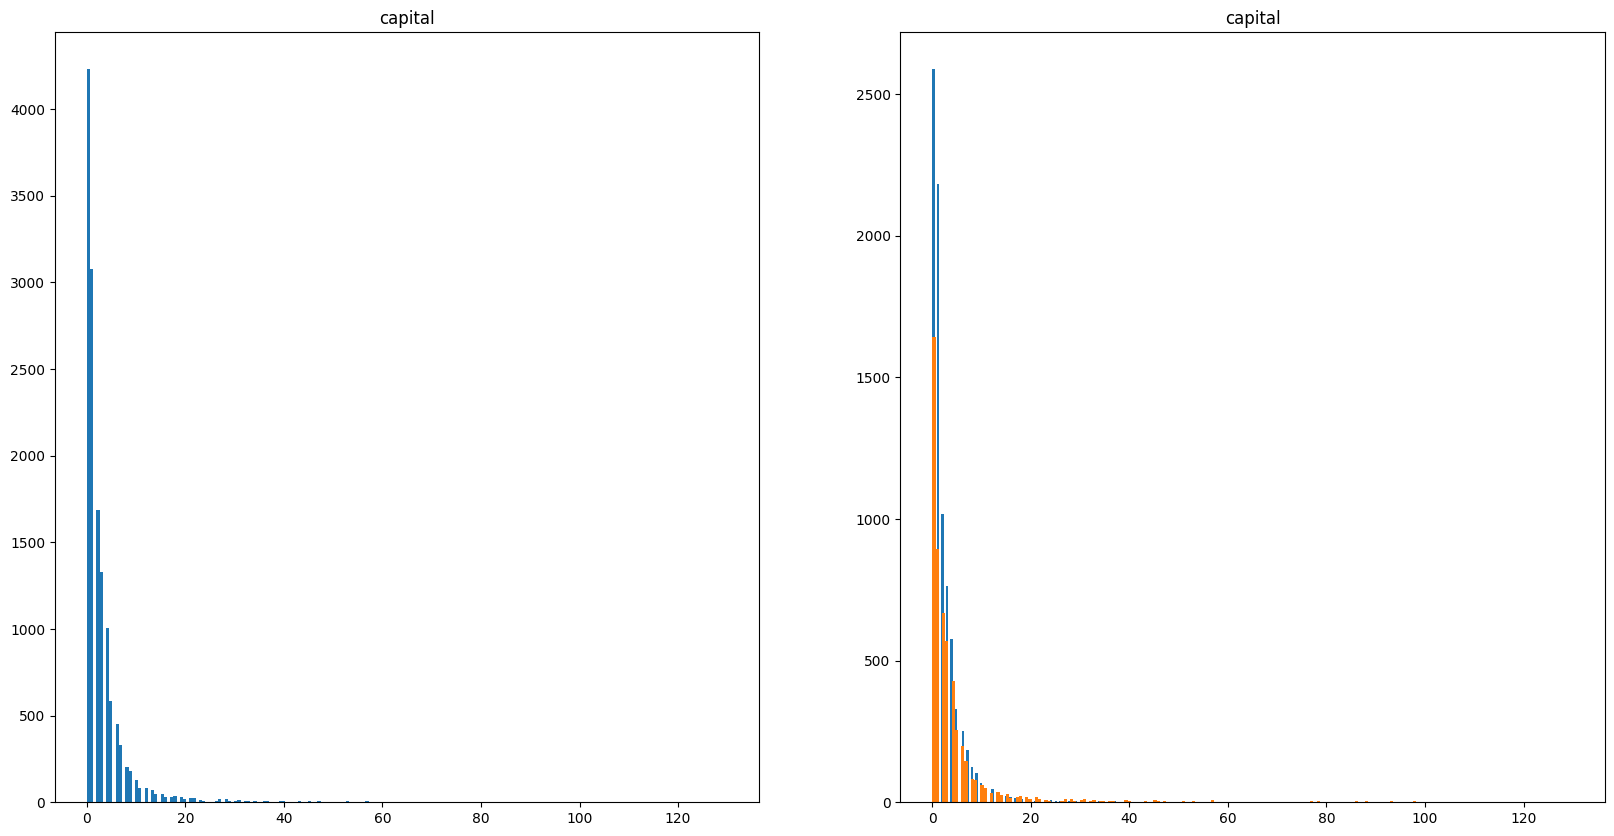

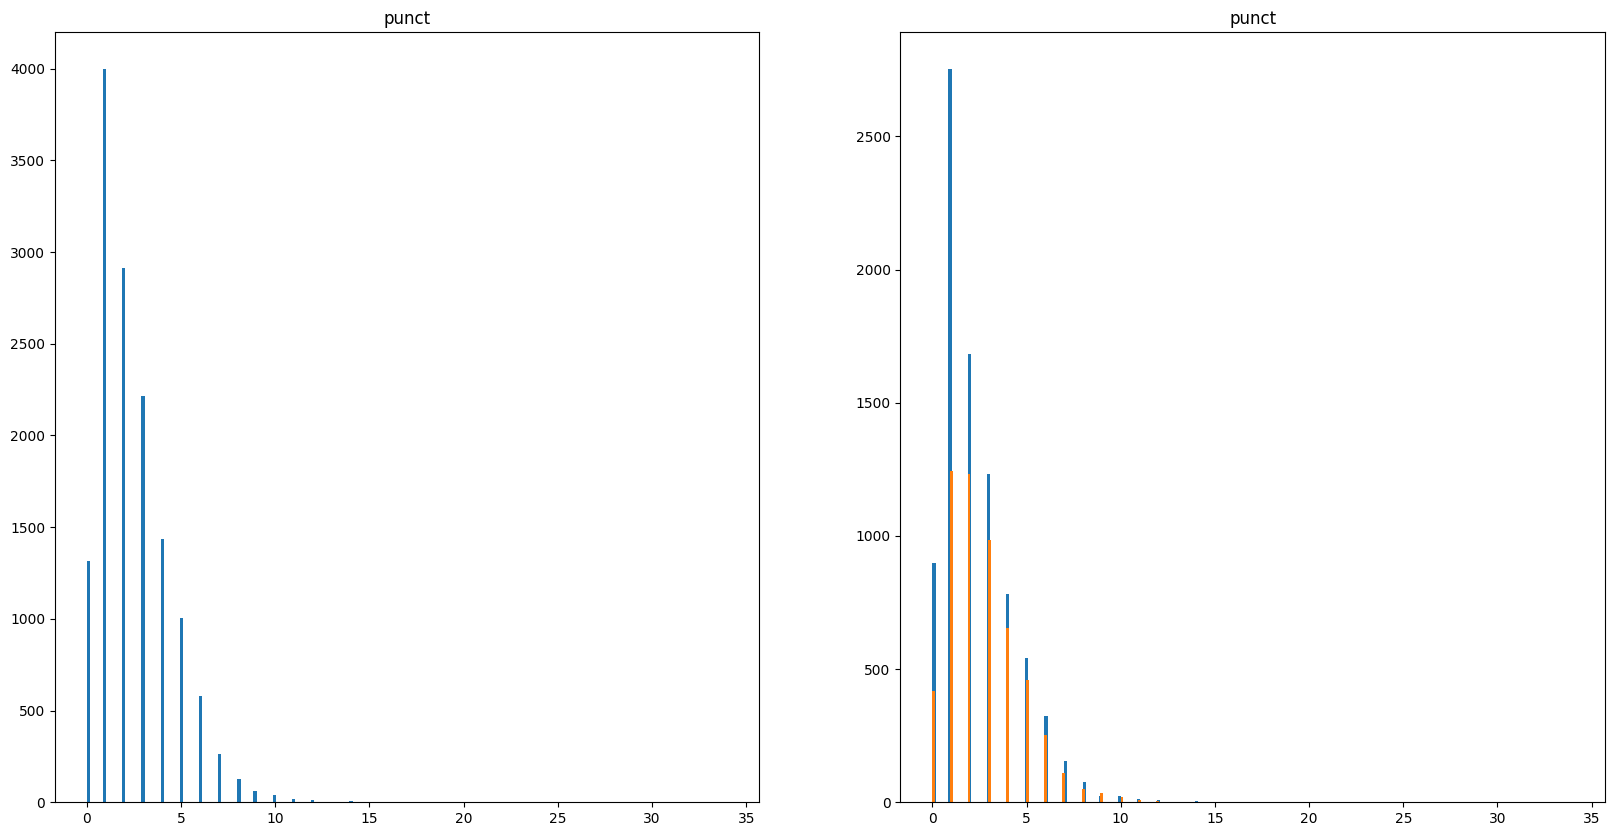

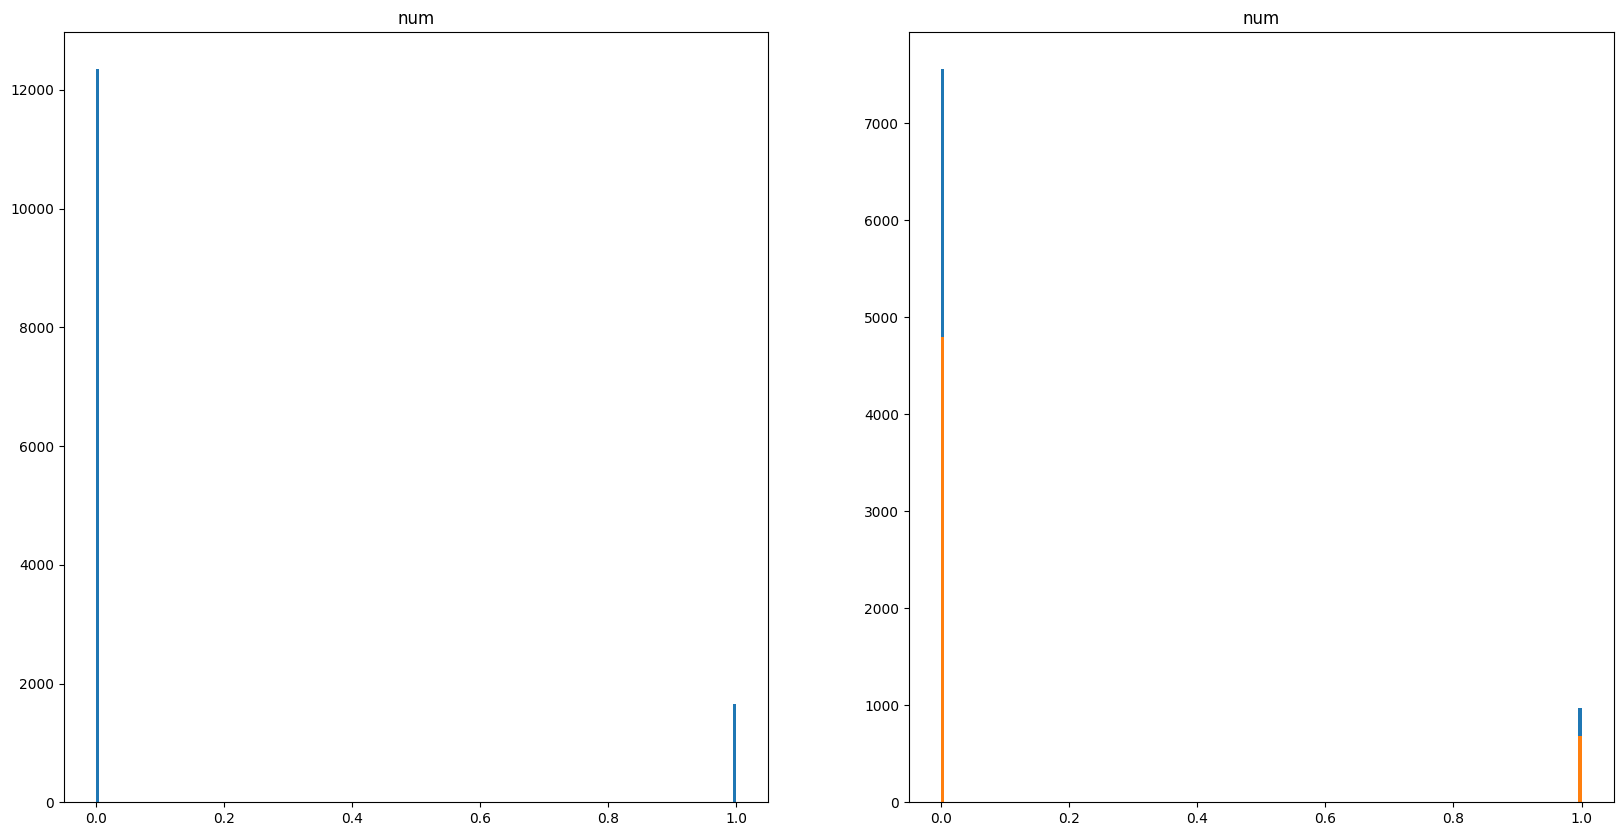

In [27]:
for col in X_train.columns[2 :] :
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
    axes[0].set_title(col)
    axes[0].hist(X_train[col], bins = 200);
    axes[1].set_title(col)
    axes[1].hist(X_train[col][X_train['label'] == 0], bins = 200, label = 'normal')
    axes[1].hist(X_train[col][X_train['label'] == 1], bins = 200, label = 'agressive')
    plt.show()

<Axes: >

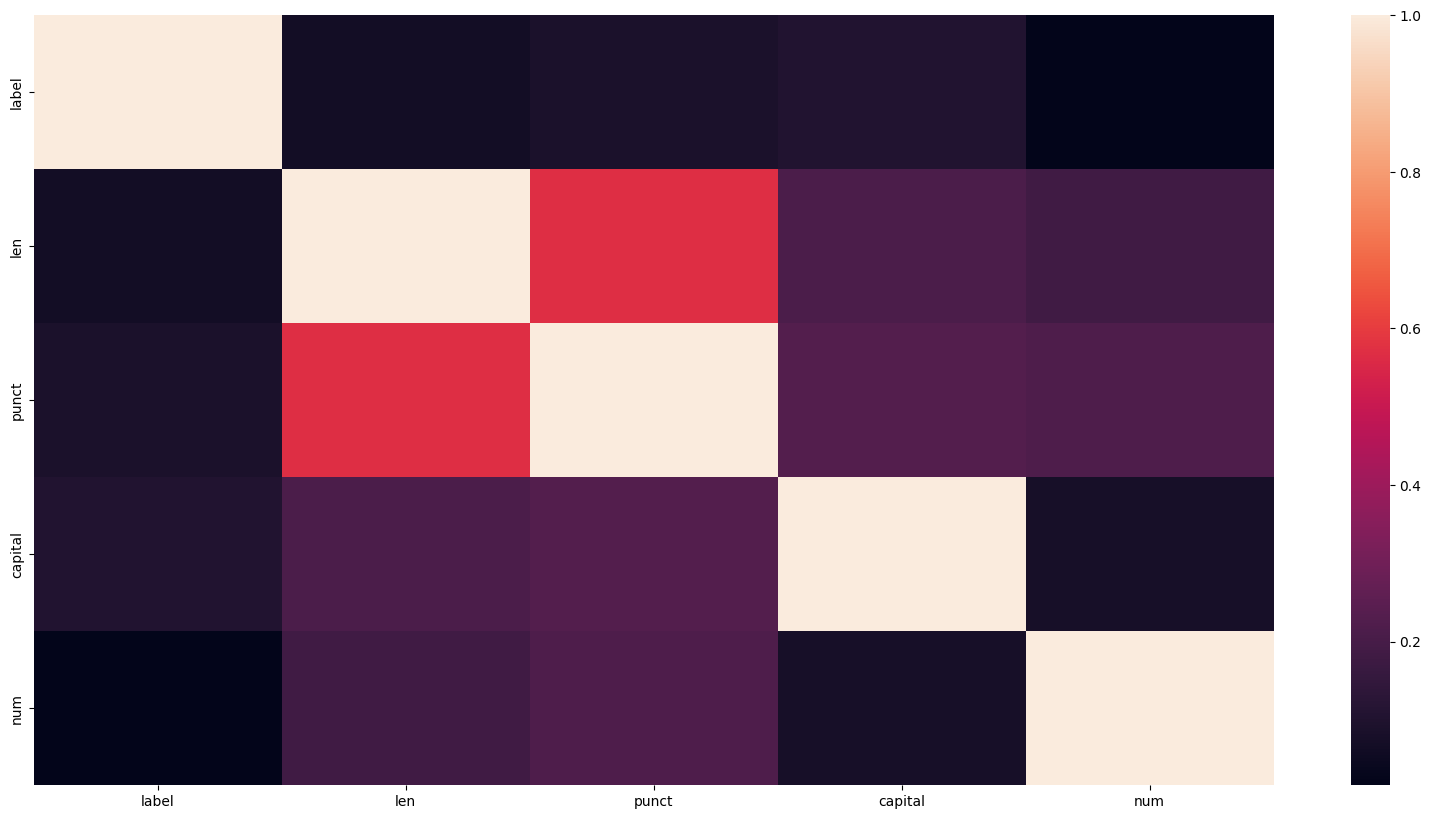

In [28]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(X_train[['label', 'len', 'punct', 'capital','num']].corr())

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


cols = ['len', 'punct', 'capital', 'num']
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[cols]), columns = cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[cols]), columns = cols)

In [34]:
def valid(model, n, bayes = False) :
    skf = StratifiedKFold(n_splits = n)
    auc_scores = []
    for train_index, valid_index in skf.split(X_train_scaled, y_train):
        X_train_part, X_valid = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
        y_train_part, y_valid = y_train[train_index], y_train[valid_index]
        
        X_train_sms, X_valid_sms = X_train.iloc[train_index]['content'], X_train.iloc[valid_index]['content']
        cv = TfidfVectorizer(ngram_range = (1, 3))
        X_train_bow = cv.fit_transform(X_train_sms)
        X_valid_bow = cv.transform(X_valid_sms)     
        if bayes :
            X_train_new = X_train_bow
            X_valid_new = X_valid_bow
        else :
            X_train_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_train_bow, X_train_part]))
            X_valid_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_valid_bow, X_valid]))
        model.fit(X_train_new, y_train_part)
        model_pred_for_auc = model.predict_proba(X_valid_new)
        auc_scores.append(roc_auc_score(y_valid, model_pred_for_auc[:, 1]))
    return np.mean(auc_scores)
     

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 31)
bayes = MultinomialNB()
     


In [35]:
from sklearn.metrics import roc_auc_score, precision_score
     


scores_logit = valid(logit,10)
print('Logistic regreession - rocauc : {}'.format(scores_logit))


Logistic regreession - rocauc : 0.8564669049751042


In [36]:
scores_bayes = valid(bayes, 10, True)
print('Bayessian classfier - rocauc : {}'.format(scores_bayes))

Bayessian classfier - rocauc : 0.9389191375355204


In [40]:
def valid_for_valid_plots(model, n, bayes = False) :
    skf = StratifiedKFold(n_splits = n)
    auc_scores_cv = []
    auc_scores_valid = []
    for train_index, valid_index in skf.split(X_train_scaled, y_train):
        X_train_part, X_valid = X_train_scaled.iloc[train_index], X_train_scaled.iloc[valid_index]
        y_train_part, y_valid = y_train[train_index], y_train[valid_index]
        
        X_train_sms, X_valid_sms = X_train.iloc[train_index]['content'], X_train.iloc[valid_index]['content']
        cv = TfidfVectorizer(ngram_range = (1, 3))
        X_train_bow = cv.fit_transform(X_train_sms)
        X_valid_bow = cv.transform(X_valid_sms)     
        if bayes :
            X_train_new = X_train_bow
            X_valid_new = X_valid_bow
        else :
            X_train_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_train_bow, X_train_part]))
            X_valid_new = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_valid_bow, X_valid]))
            
        model.fit(X_train_new, y_train_part)
        auc_scores_cv.append(roc_auc_score(y_train_part, model.predict_proba(X_train_new)[:, 1]))
        model_pred_for_auc = model.predict_proba(X_valid_new)
        auc_scores_valid.append(roc_auc_score(y_valid, model_pred_for_auc[:, 1]))
    return 1 - np.mean(auc_scores_valid), 1 - np.mean(auc_scores_cv)

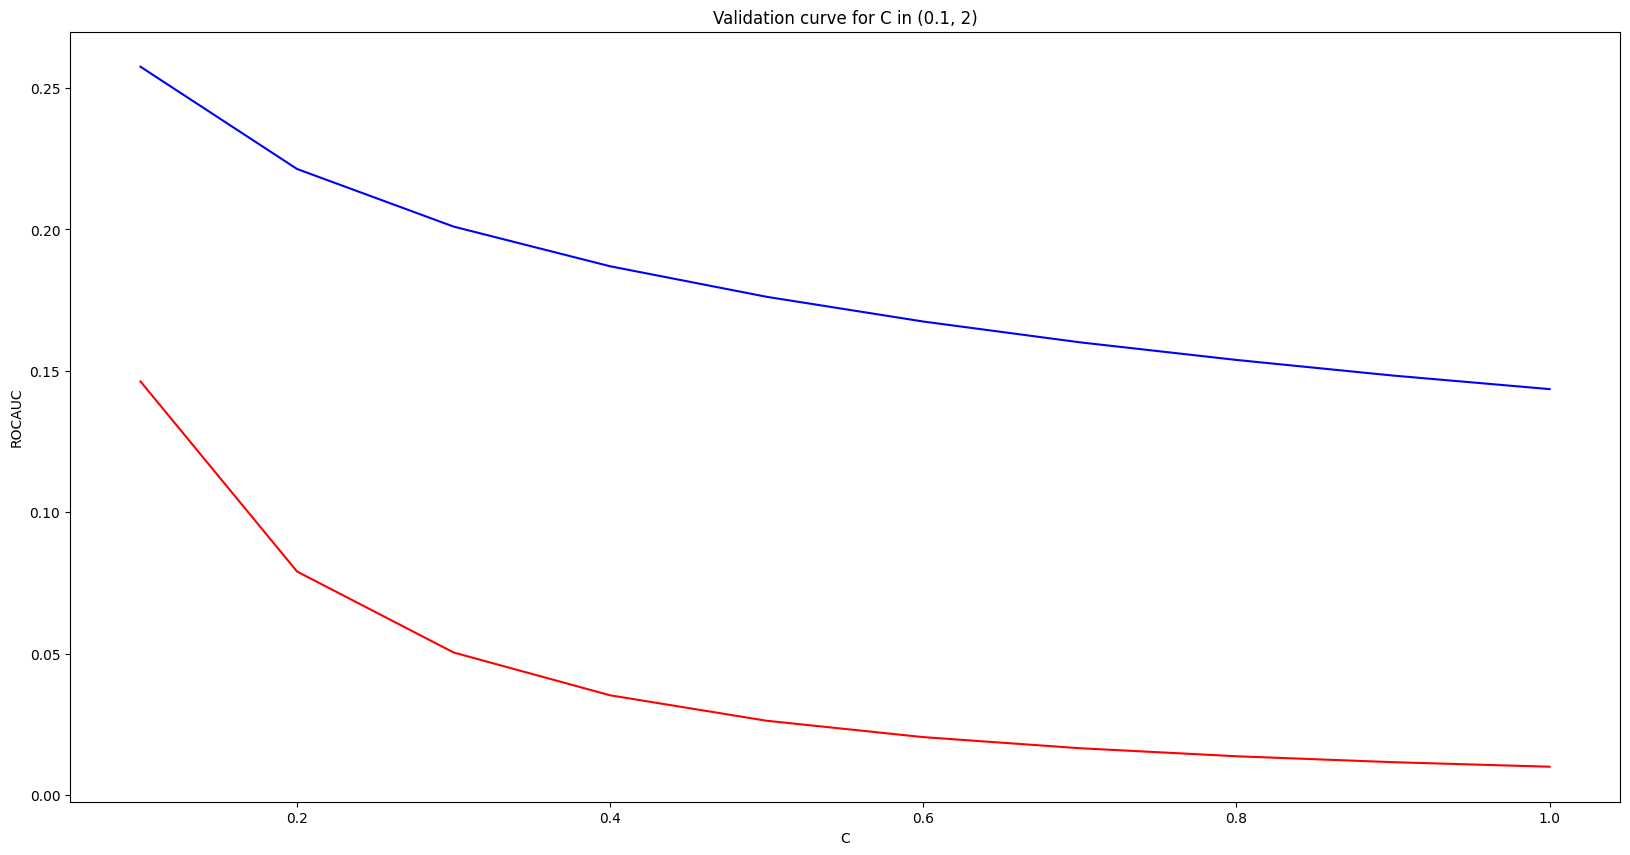

In [41]:
Cs = [0.1 * i for i in range(1, 11)]
     


scores = []
for c in Cs :
    logit = LogisticRegression(C = c)
    scores.append(valid_for_valid_plots(logit, 10))
     
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
plt.plot(Cs, [i[0] for i in scores], color = 'blue', label='holdout')
plt.plot(Cs, [i[1] for i in scores], color = 'red', label='CV')
plt.ylabel("ROCAUC")
plt.xlabel("C")
plt.title('Validation curve for C in (0.1, 2)');

In [42]:
Cs = np.linspace(0.5, 1.5, 10)


for c in Cs :
    logit = LogisticRegression(C = c)
    print(c, valid(logit, 10))
     


0.5 0.8238382575476747
0.6111111111111112 0.8334277734049799
0.7222222222222222 0.8414295079968029
0.8333333333333333 0.8481855796201245
0.9444444444444444 0.8539361618532009
1.0555555555555556 0.8589981736213487
1.1666666666666665 0.8632488680732147
1.2777777777777777 0.8671236296163498
1.3888888888888888 0.8708299982763561
1.5 0.8739309745125476


In [44]:
C_opt = 1.5
     
cv = TfidfVectorizer(ngram_range = (1, 3))
X_train_content = cv.fit_transform(X_train['content'])
X_test_content = cv.transform(X_test['content'])
     
train = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_train_content, X_train_scaled]))
test = scipy.sparse.csr_matrix(scipy.sparse.hstack([X_test_content, X_test_scaled]))

logit = LogisticRegression(C = C_opt)
     
logit.fit(train, y_train)

for x, y in zip(cols, logit.coef_[0][len(cv.get_feature_names_out()) :]) :
    print(x, y)

len 0.11116761216567485
punct 0.09610396516747838
capital 0.14780349993616945
num -0.01509124644832998


In [45]:
logit_pred = logit.predict_proba(test)
     
roc_auc_score(y_test, logit_pred[:, 1])


0.8728922130733687